<ipython-input-2-48666ddd1e01>:20: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  binary_encoded = housing_data[categorical_features].replace({"yes": 1, "no": 0, "furnished": 2, "semi-furnished": 1, "unfurnished": 0})


Epoch 1/50, Train Loss: 1.0055, Val Loss: 1.6424
Epoch 2/50, Train Loss: 0.9753, Val Loss: 1.5999
Epoch 3/50, Train Loss: 0.9459, Val Loss: 1.5563
Epoch 4/50, Train Loss: 0.9158, Val Loss: 1.5100
Epoch 5/50, Train Loss: 0.8840, Val Loss: 1.4596
Epoch 6/50, Train Loss: 0.8505, Val Loss: 1.4060
Epoch 7/50, Train Loss: 0.8157, Val Loss: 1.3496
Epoch 8/50, Train Loss: 0.7793, Val Loss: 1.2908
Epoch 9/50, Train Loss: 0.7417, Val Loss: 1.2305
Epoch 10/50, Train Loss: 0.7034, Val Loss: 1.1684
Epoch 11/50, Train Loss: 0.6647, Val Loss: 1.1054
Epoch 12/50, Train Loss: 0.6260, Val Loss: 1.0424
Epoch 13/50, Train Loss: 0.5881, Val Loss: 0.9809
Epoch 14/50, Train Loss: 0.5519, Val Loss: 0.9210
Epoch 15/50, Train Loss: 0.5176, Val Loss: 0.8639
Epoch 16/50, Train Loss: 0.4859, Val Loss: 0.8103
Epoch 17/50, Train Loss: 0.4570, Val Loss: 0.7613
Epoch 18/50, Train Loss: 0.4311, Val Loss: 0.7182
Epoch 19/50, Train Loss: 0.4085, Val Loss: 0.6825
Epoch 20/50, Train Loss: 0.3889, Val Loss: 0.6538
Epoch 21/

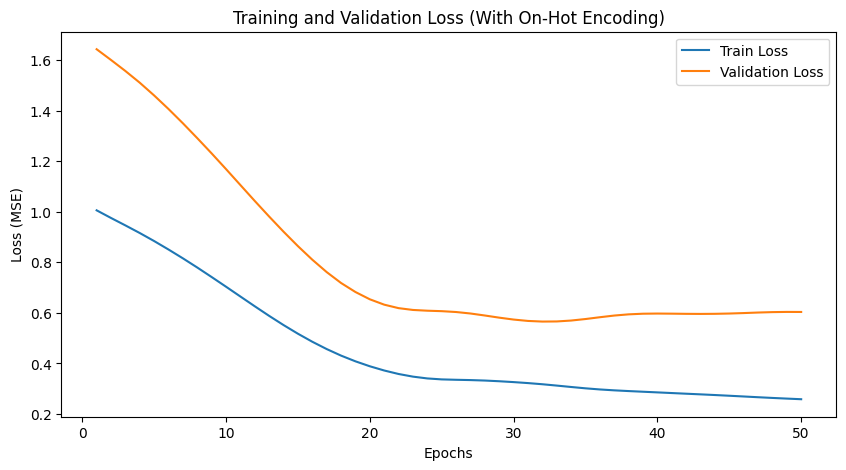

Final Mean Squared Error (MSE): 0.6036
Final Mean Absolute Error (MAE - Original Scale): 1000812.50
Final Accuracy: 80.01%
Model Complexity (Total Trainable Parameters): 11905


In [2]:
### on-hot encoding

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt


housing_data = pd.read_csv("Housing.csv")

####Separate numerical and categorical features
numerical_features = ["area", "bedrooms", "bathrooms", "stories", "parking"]
categorical_features = ["mainroad", "guestroom", "basement", "hotwaterheating", "airconditioning", "furnishingstatus"]
target = "price"

#On-Hot Encoding
binary_encoded = housing_data[categorical_features].replace({"yes": 1, "no": 0, "furnished": 2, "semi-furnished": 1, "unfurnished": 0})

#Combine numerical and binary-encoded
X = pd.concat([housing_data[numerical_features], binary_encoded], axis=1)
y = housing_data[target]

###train 80% and test 20% sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Scale numerical features and target variable
scaler_X = StandardScaler()
X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)

scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))



#Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_scaled, dtype=torch.float32)


#Define the MLP model
class HousingMLP(nn.Module):
    def __init__(self, input_dim):
        super(HousingMLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.fc4(x)
        return x


# Initialize model, loss function, and optimizer
input_dim = X_train.shape[1]
model = HousingMLP(input_dim)
criterion = nn.MSELoss()  # Mean Squared Error for regression
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
epochs = 50
train_losses, val_losses = [], []

for epoch in range(epochs):
    # Training phase
    model.train()
    optimizer.zero_grad()
    predictions = model(X_train_tensor)
    train_loss = criterion(predictions, y_train_tensor)
    train_loss.backward()
    optimizer.step()

         ### Validation phase
    model.eval()
    with torch.no_grad():
        val_predictions = model(X_test_tensor)
        val_loss = criterion(val_predictions, y_test_tensor)

    # Save losses
    train_losses.append(train_loss.item())
    val_losses.append(val_loss.item())

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss.item():.4f}, Val Loss: {val_loss.item():.4f}")

#Plots
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs+1), train_losses, label="Train Loss")
plt.plot(range(1, epochs+1), val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.title("Training and Validation Loss (With On-Hot Encoding)")
plt.legend()
plt.show()

    ##### Evaluate model performance
model.eval()
with torch.no_grad():
    test_predictions = model(X_test_tensor)
    mse = criterion(test_predictions, y_test_tensor).item()
    mae = torch.mean(torch.abs(test_predictions - y_test_tensor)).item()
    # Convert predictions back to original scale
    test_predictions_original = scaler_y.inverse_transform(test_predictions.numpy())
    y_test_original = scaler_y.inverse_transform(y_test_tensor.numpy())
    mae_original = torch.mean(torch.abs(torch.tensor(test_predictions_original) - torch.tensor(y_test_original))).item()

#    ## Calculate accuracy
mean_target_value = y_test_original.mean()
accuracy = 1 - (mae_original / mean_target_value)



#### model complexity
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)


print(f"Final Mean Squared Error (MSE): {mse:.4f}")
print(f"Final Mean Absolute Error (MAE - Original Scale): {mae_original:.2f}")
print(f"Final Accuracy: {accuracy * 100:.2f}%")
print(f"Model Complexity (Total Trainable Parameters): {total_params}")
